In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
Seeds = [512, 166, 538, 894, 449, 195, 88, 144, 903, 577, 830, 827, 537, 179, 660, 844, 999, 858, 744, 740, 221, 443, 219, 484, 5, 23, 465, 864, 245, 523]

class AlgorithmComparisonData():
    def __init__(self, wins, significant_wins, defeats, significant_defeats):
        self.wins = wins
        self.significant_wins = significant_wins
        self.defeats = defeats
        self.significant_defeats = significant_defeats

    def __str__(self):
        return f"wins: {self.wins}({self.significant_wins})\ndefeats: {self.defeats}({self.significant_defeats})"

class ExperimentsDataAnalyzer():

    def __init__(self):
        self.data_lake = {}

    def load_data(self, data_source_name, data_source_path):
        df = pd.read_csv(data_source_path, sep=';')
        self.data_lake[data_source_name] = df

    def get_data_frame(self, data_source_name):
        return self.data_lake[data_source_name].copy()

    def compare(self, ref_alg_datasource_name, target_alg_datasource_name):
        ref_df = self.get_data_frame(ref_alg_datasource_name)
        tgt_df = self.get_data_frame(target_alg_datasource_name)
        
        wins, swins = 0, 0 
        defeats, sdefeats = 0, 0
    
        for i in range(len(tgt_df)):
            data1 = ref_df.iloc[i][1:]
            data2 = tgt_df.iloc[i][1:]
            
            d1_mean = np.mean(data1)
            d2_mean = np.mean(data2) 
        
            is_signif = False
            if d1_mean == 0.0 and d2_mean == 0.0:
                is_signif = False
            else:
                stat, p = wilcoxon(data1, data2, zero_method="zsplit", )
                if p <= 0.05:
                    is_signif = True
            
            if d1_mean > d2_mean:
                wins += 1
                if is_signif:
                    swins += 1
        
            elif d1_mean < d2_mean:
                defeats += 1
                if is_signif:
                    sdefeats += 1

        return AlgorithmComparisonData(wins, swins, defeats, sdefeats)

In [ ]:
analyzer = ExperimentsDataAnalyzer()

D=10
for func_number in range(30):
    seed = Seeds[func_number]
    config = "--dmlshade --crossgen --insert --er 0.1 --cr 0.1296 --gs 70 --sf  --analysis "
    BASE_PATH = f"~/Code/FIM-CGRASP/results/generations/DM_LSHADE/{config}/cec-f{func_number+1}/s{seed}/"
    
    analyzer.load_data(f"pop-costs-f{func_number+1}", BASE_PATH + "pop-costs.csv")
    pop_costs_df = analyzer.get_data_frame(f"pop-costs-f{func_number+1}")
    gens_count = len(pop_costs_df)
    pop_generations = {}
    for i in range(gens_count-1):
        analyzer.load_data(f"pop-f{func_number+1}-g{i+1}", BASE_PATH + "population/" + f"g{i+1}.csv")
        analyzer.load_data(f"elite-f{func_number+1}-g{i+1}", BASE_PATH + "elite/" + f"g{i+1}.csv")

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


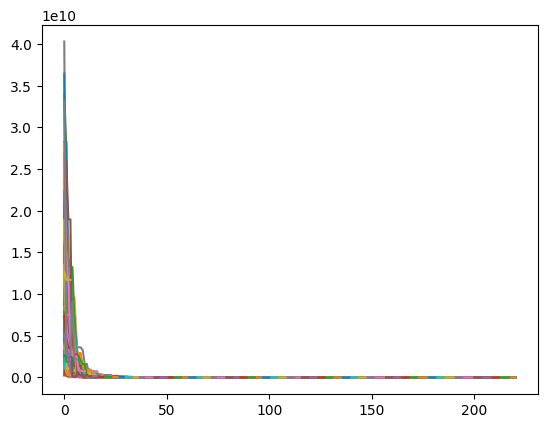

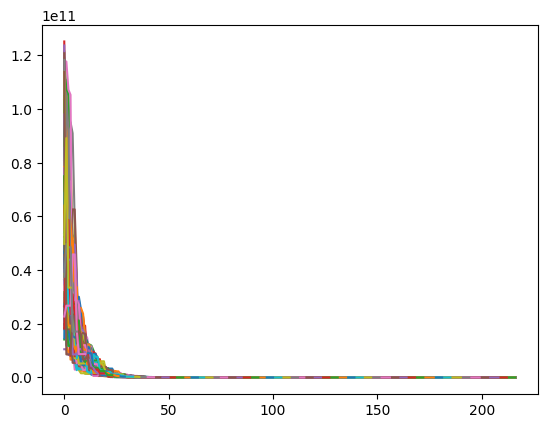

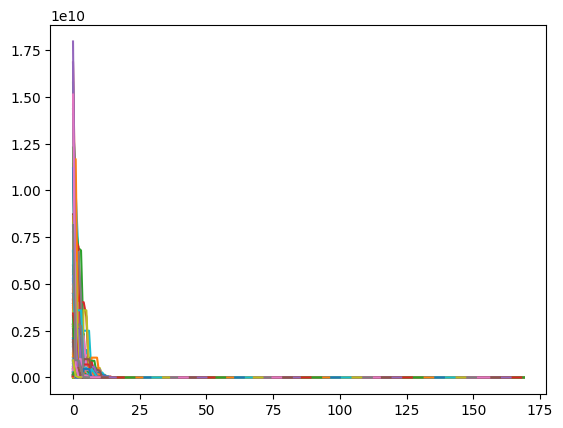

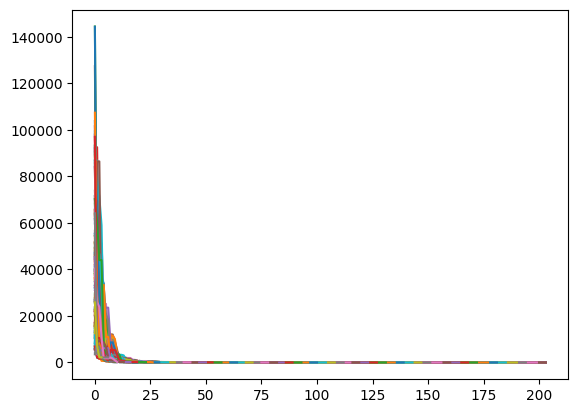

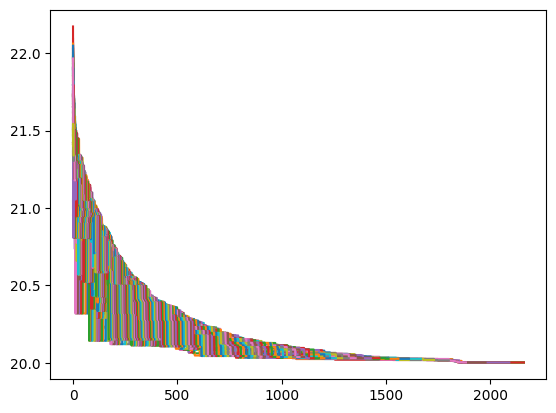

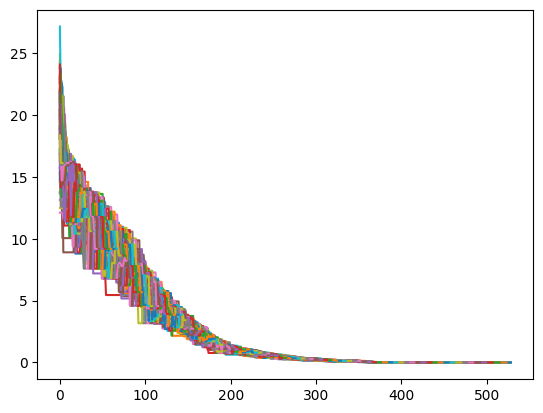

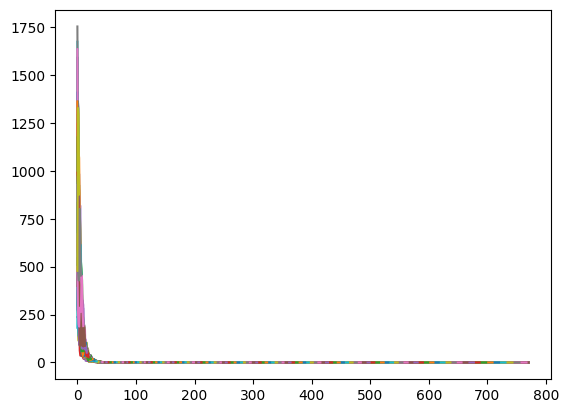

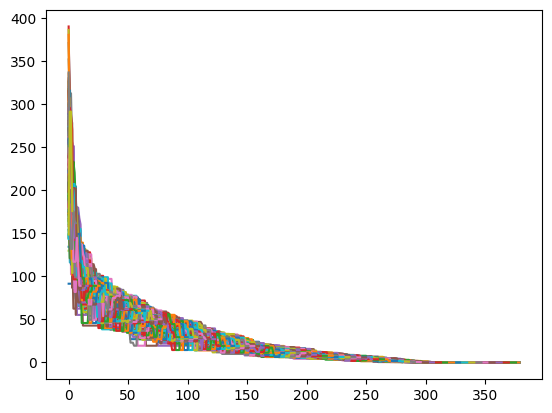

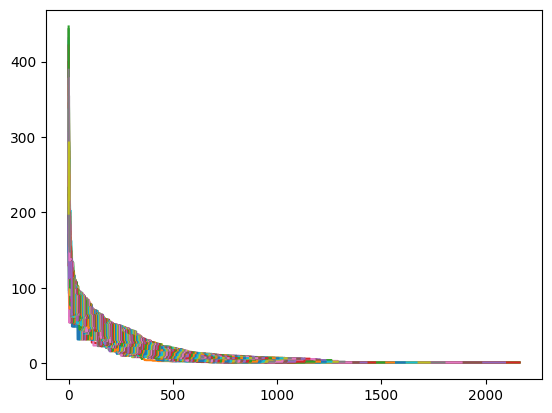

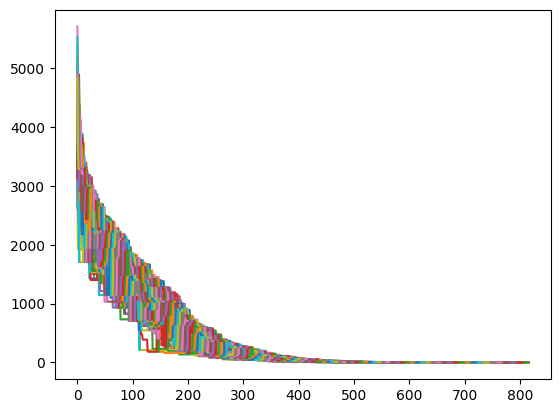

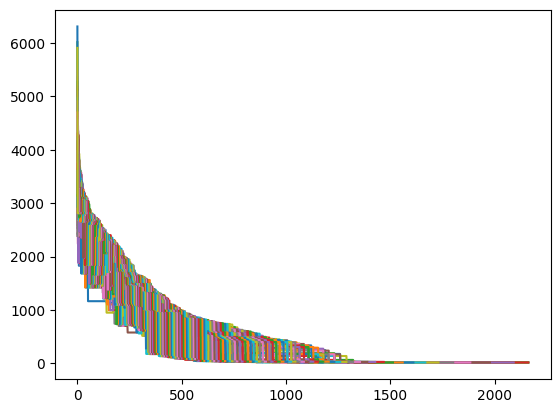

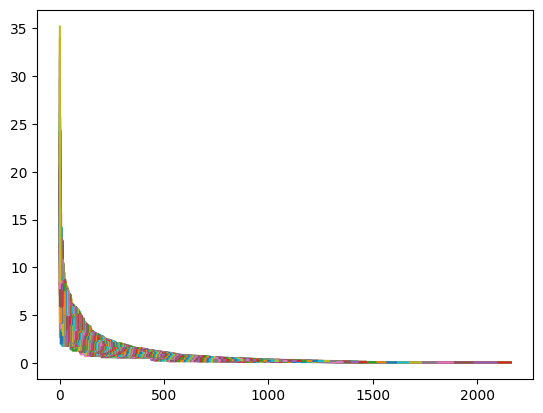

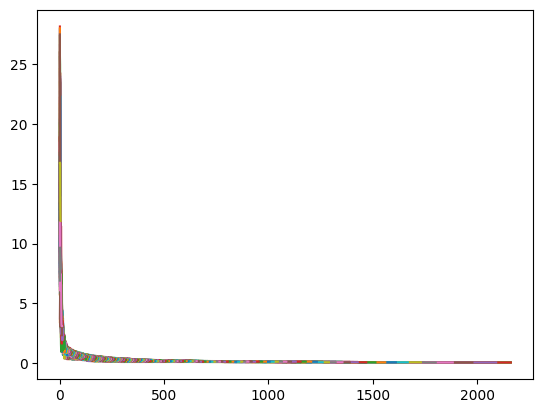

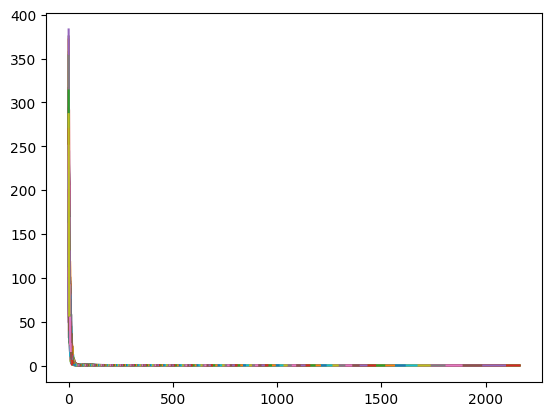

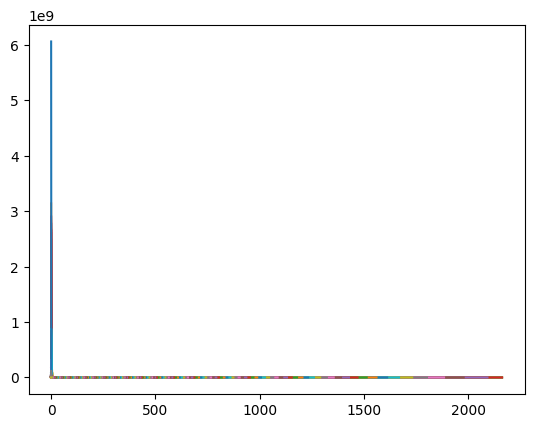

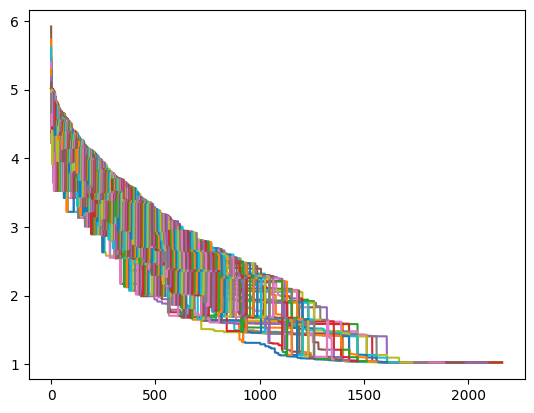

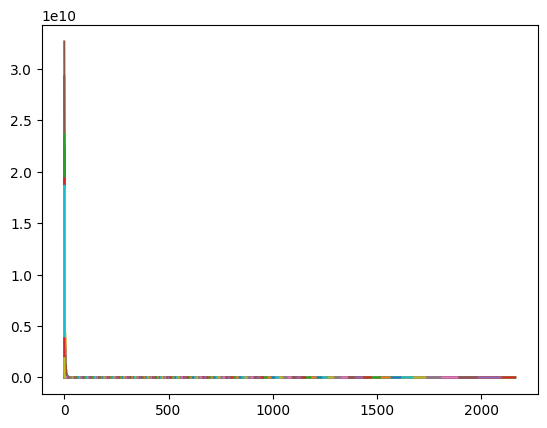

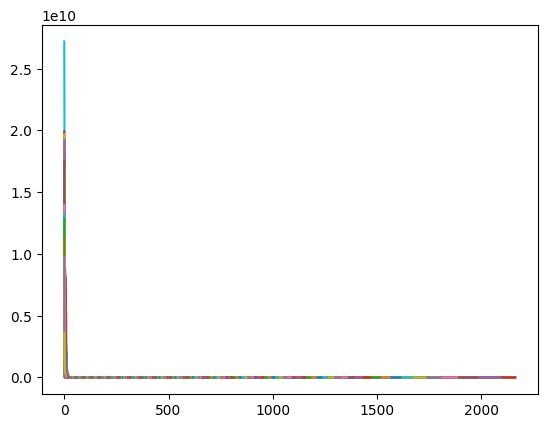

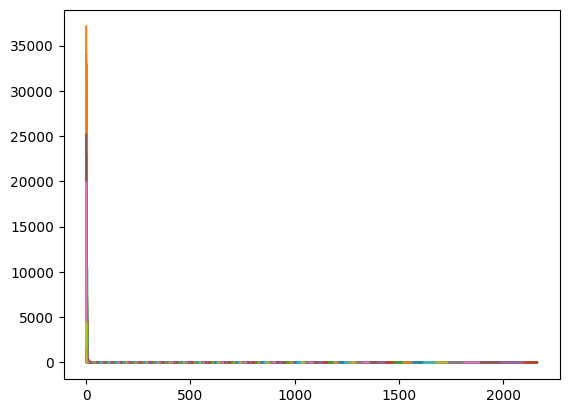

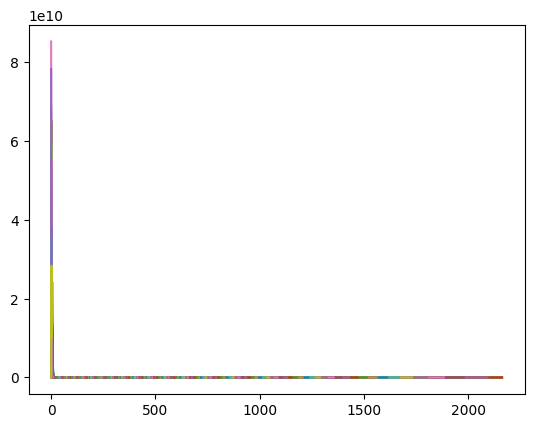

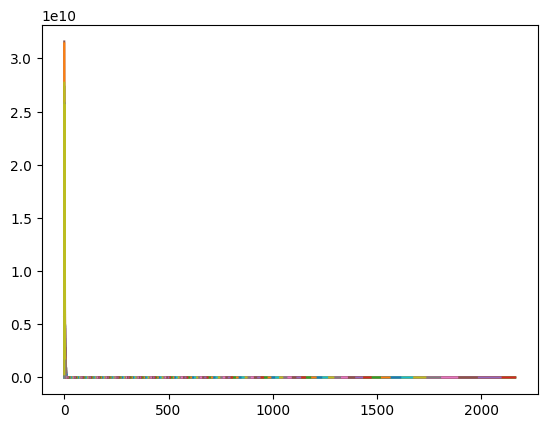

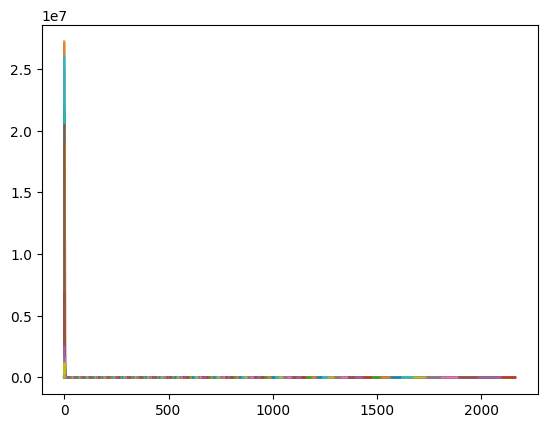

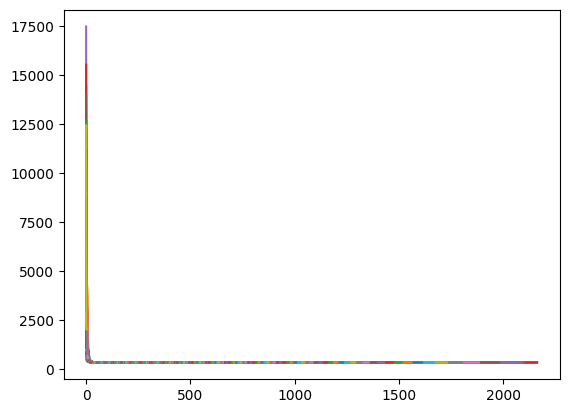

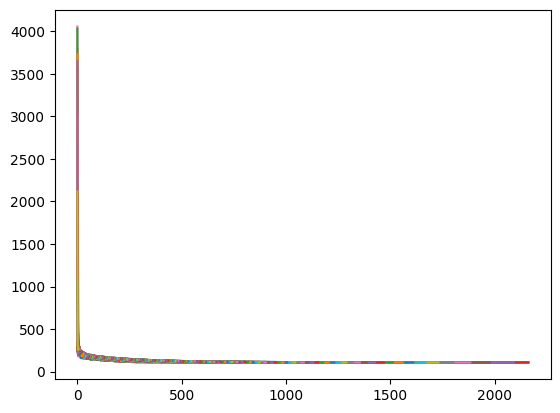

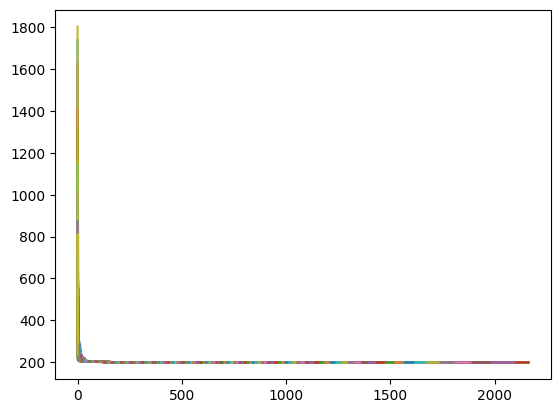

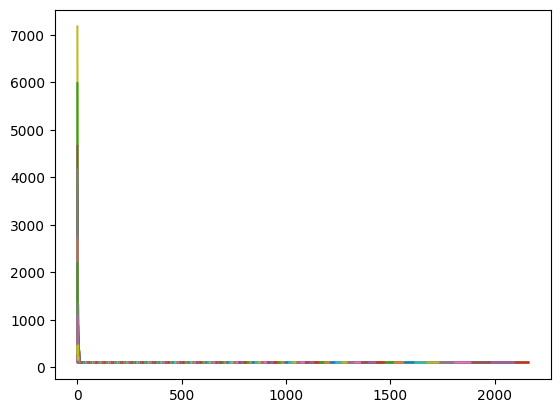

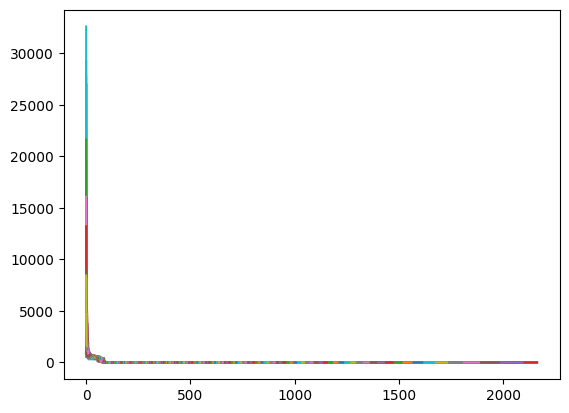

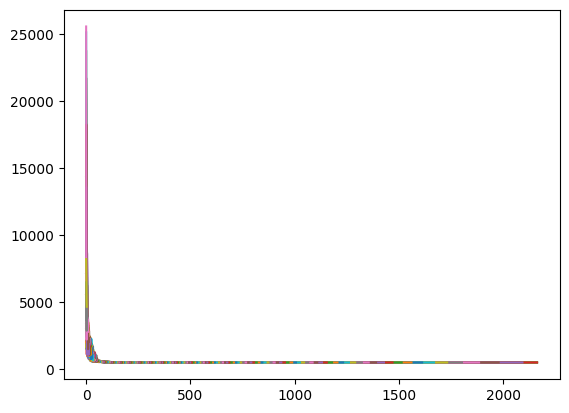

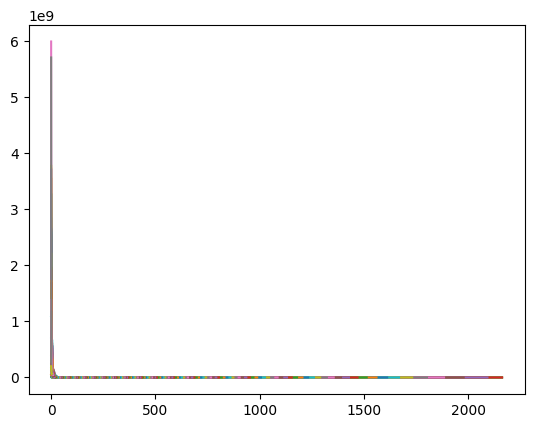

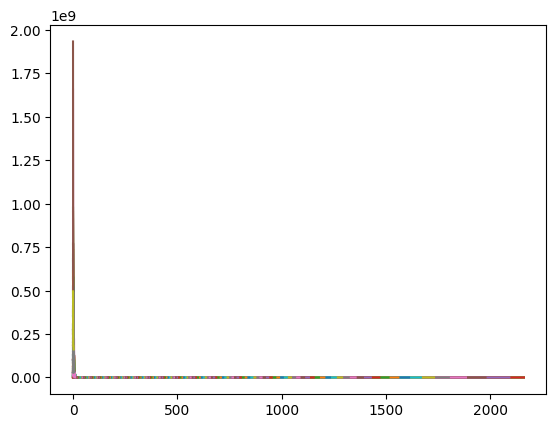

In [104]:
# Cost evolution for all individuals:
def plot_cost_evolution(func_number, algorithm="dm_lshade"):
    pop_costs_df = analyzer.get_data_frame(f"pop-costs-f{func_number}")
    pop_costs_df[pop_costs_df != -1].plot(legend=False)

for f in range(30):
    plot_cost_evolution(f+1)

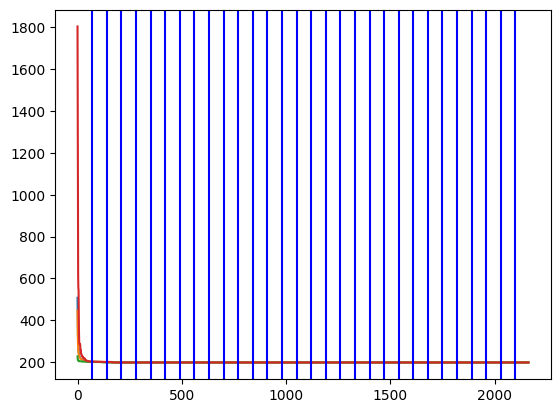

In [99]:
# Cost statistics evolution:
mean_costs = pop_costs_df[pop_costs_df != -1].mean(axis=1).plot()
median_costs = pop_costs_df[pop_costs_df != -1].median(axis=1).plot()
min_costs = pop_costs_df[pop_costs_df != -1].min(axis=1).plot()
max_costs = pop_costs_df[pop_costs_df != -1].max(axis=1).plot()

for dmg in range(70, gens_count, 70): 
    plt.axvline(x = dmg, color = 'b', label = 'axvline - full height')